[1] loss: 12542.975


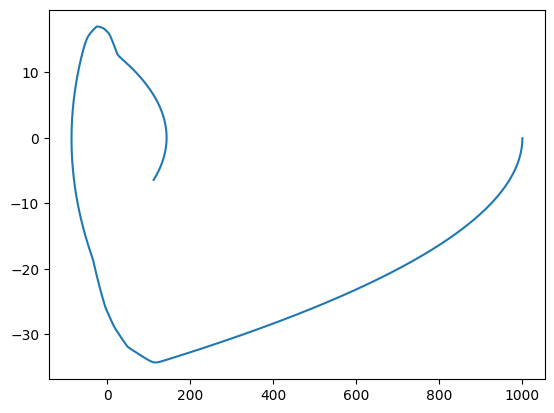

[2] loss: 4578.582


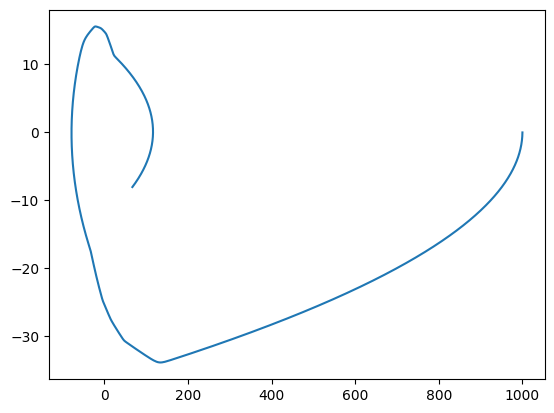

[3] loss: 2344.130


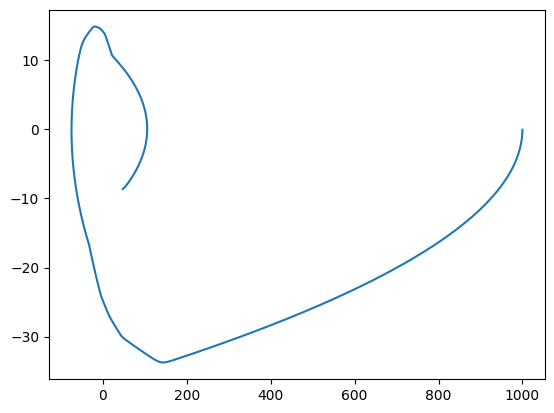

[4] loss: 1508.172


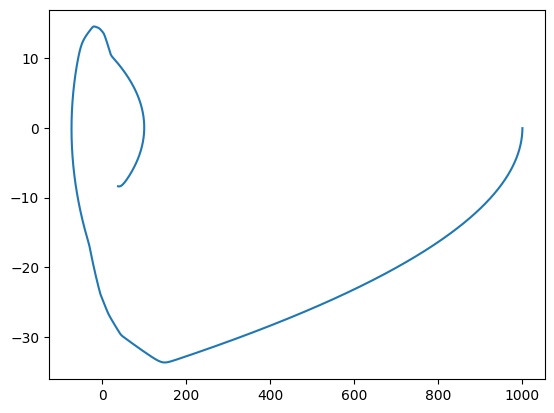

[5] loss: 1082.166


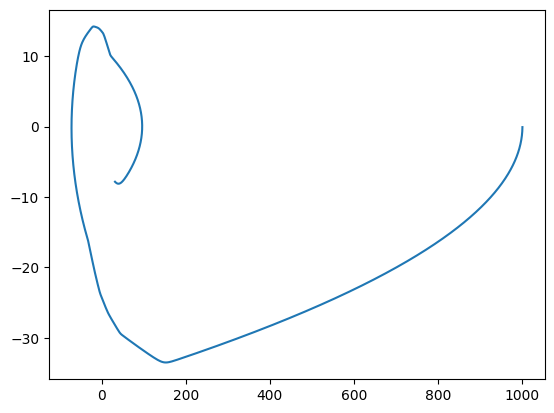

[6] loss: 783.442


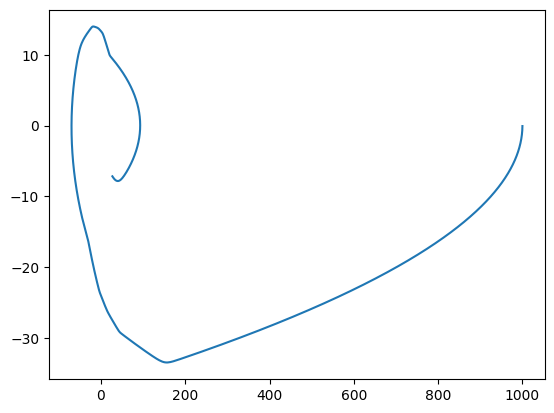

[7] loss: 588.109


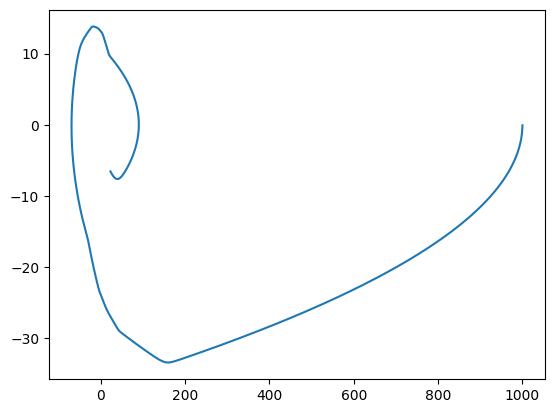

[8] loss: 441.846


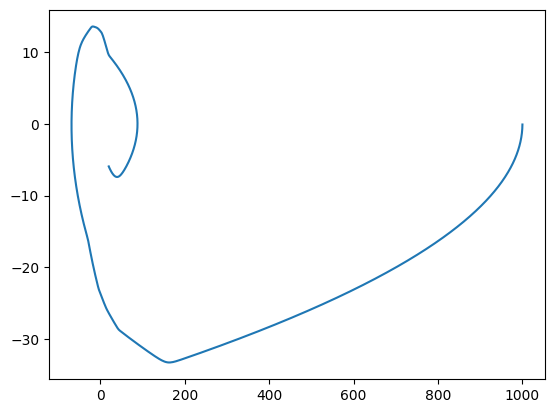

[9] loss: 329.465


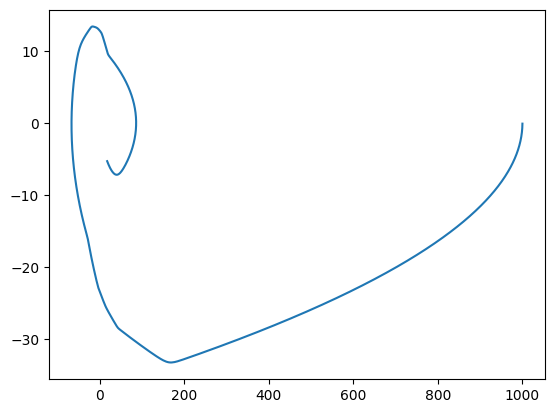

[10] loss: 244.119


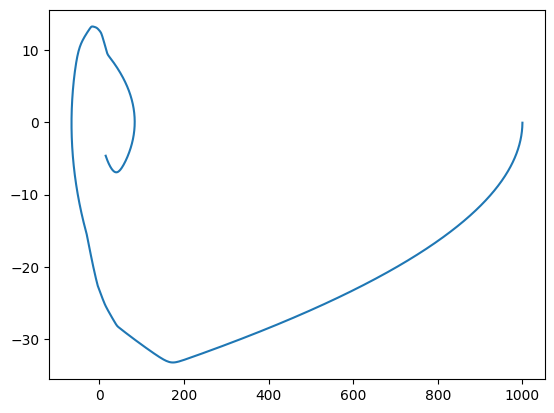

[11] loss: 180.767


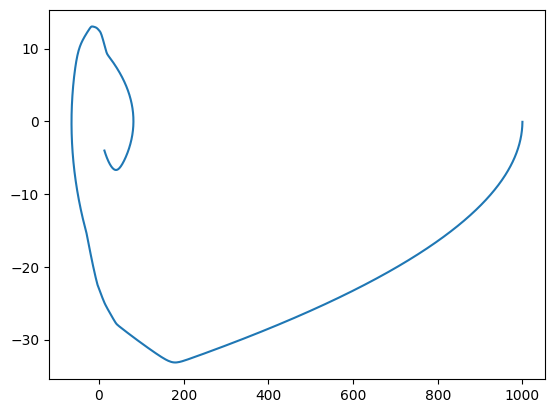

[12] loss: 138.157


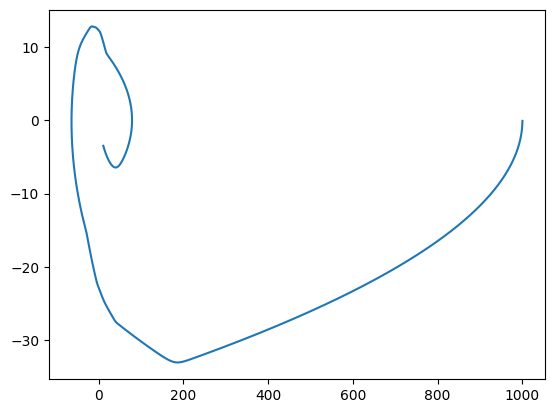

[13] loss: 106.252


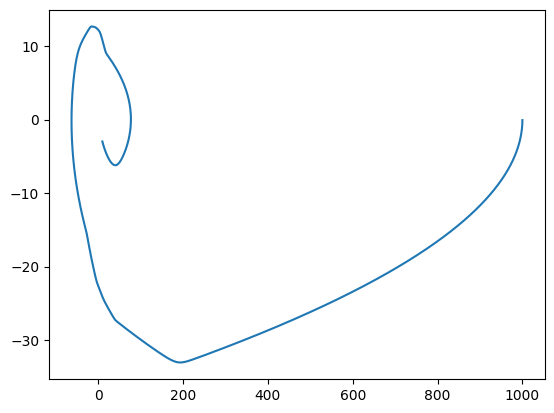

[14] loss: 83.823


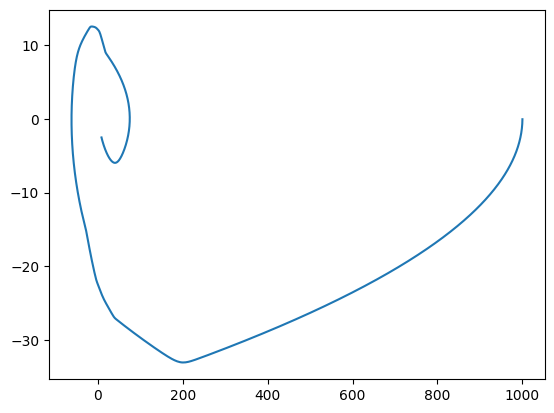

[15] loss: 67.597


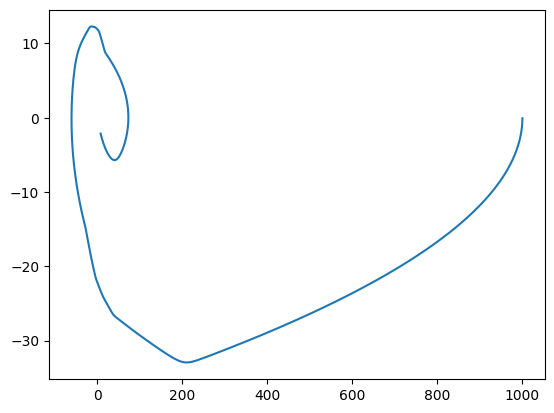

[16] loss: 57.245


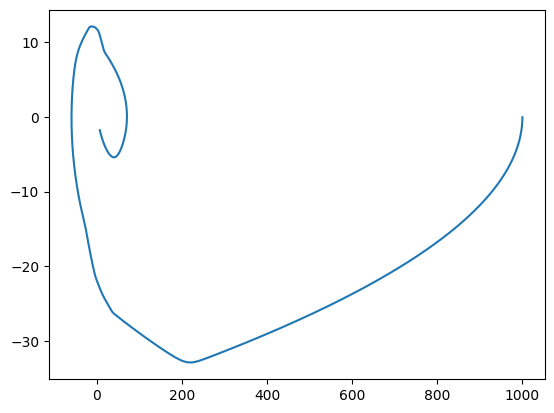

[17] loss: 50.118


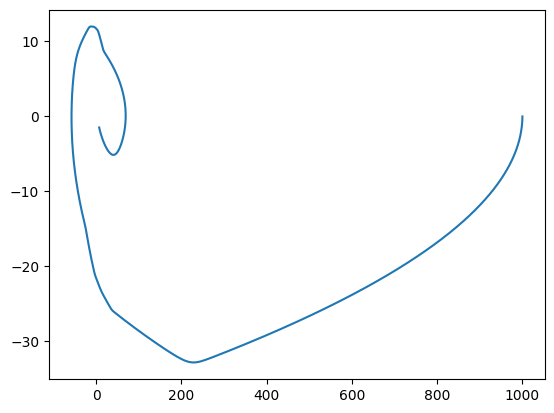

[18] loss: 43.804


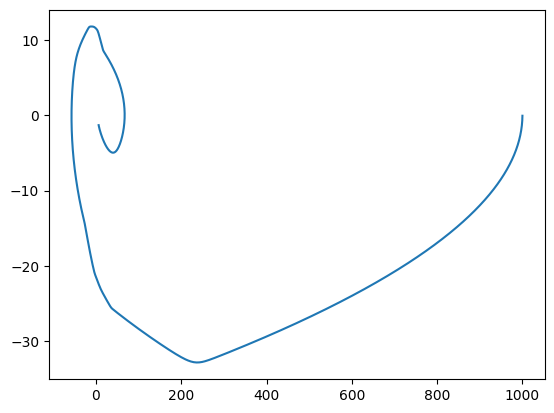

[19] loss: 33.227


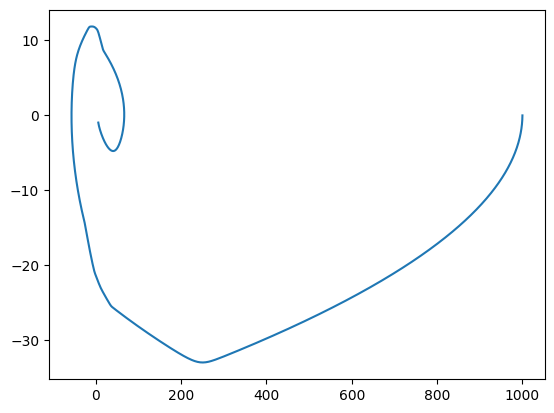

[20] loss: 20.732


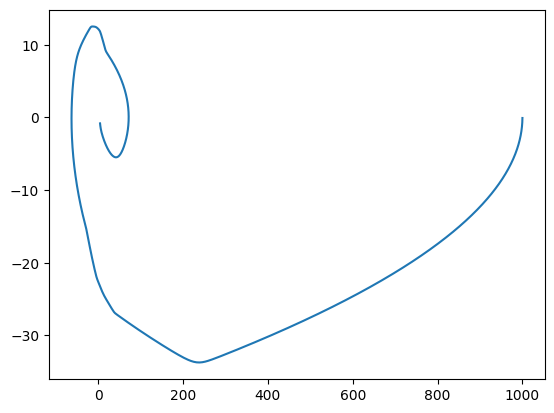

[21] loss: 15.147


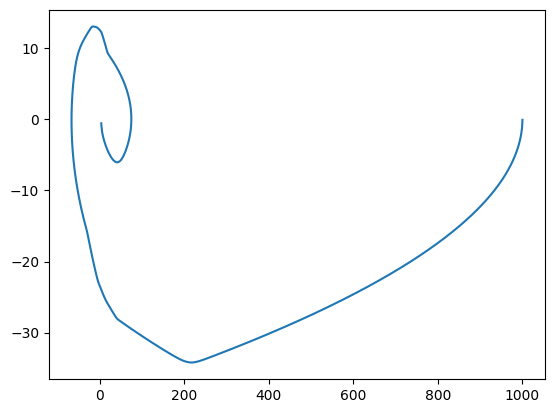

[22] loss: 13.747


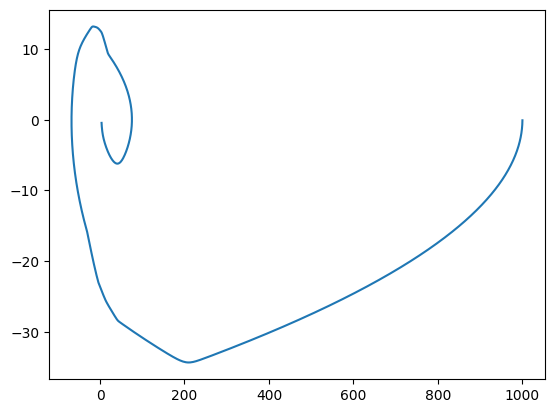

[23] loss: 10.056


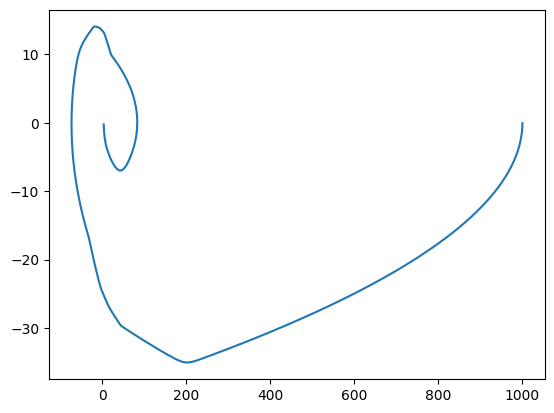

[24] loss: 7.809


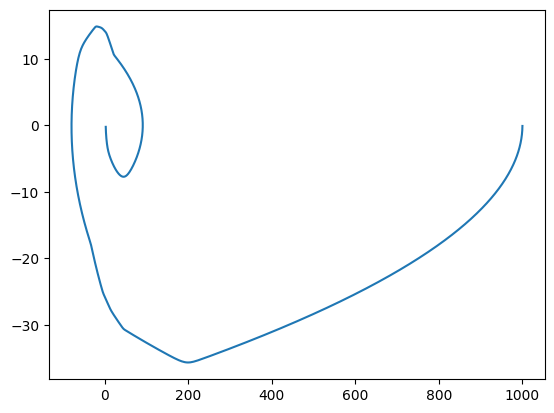

[25] loss: 5.497


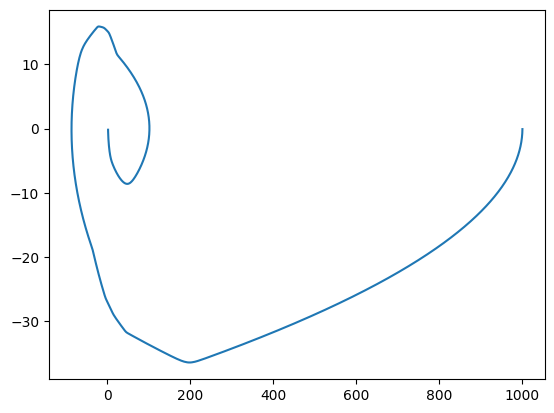

[26] loss: 2.726


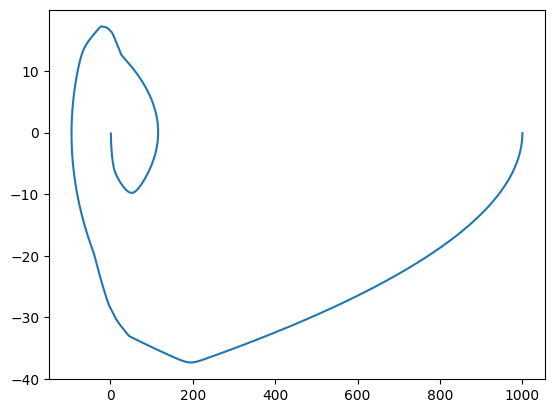

[27] loss: 89.647


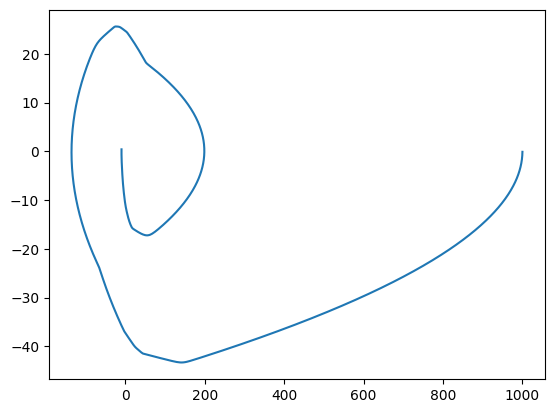

[28] loss: 11.862


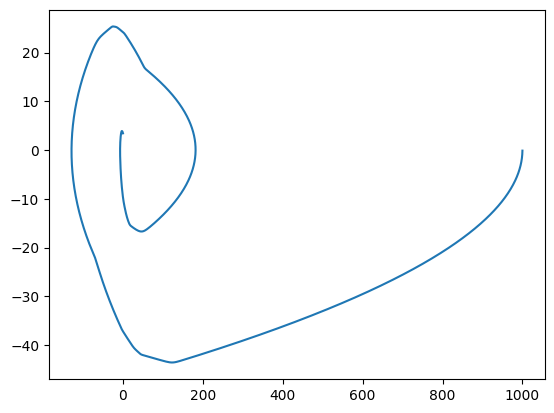

[29] loss: 10.321


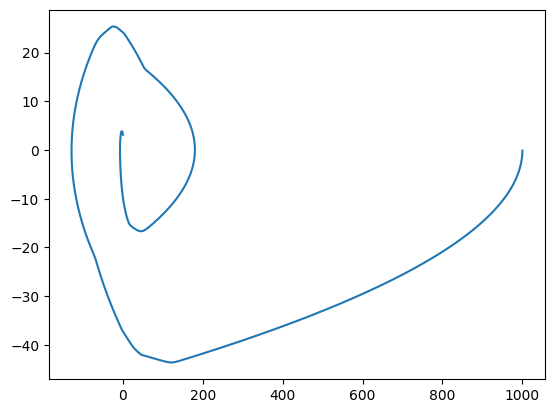

[30] loss: 9.571


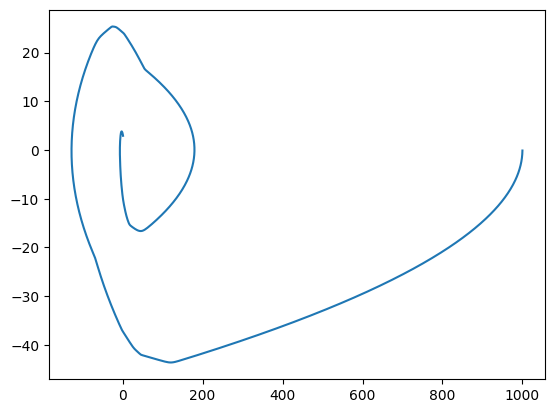

[31] loss: 8.938


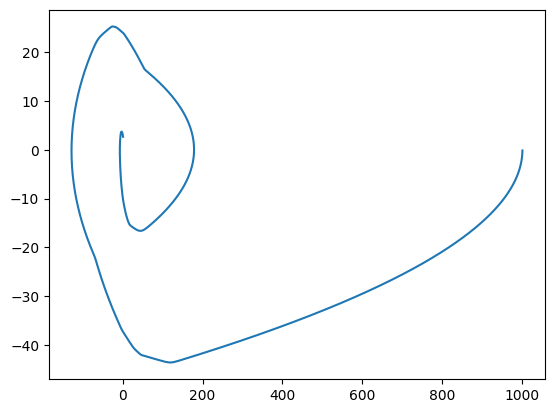

[32] loss: 8.197


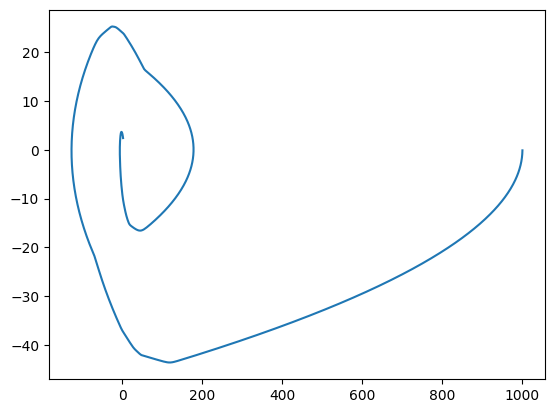

[33] loss: 7.226


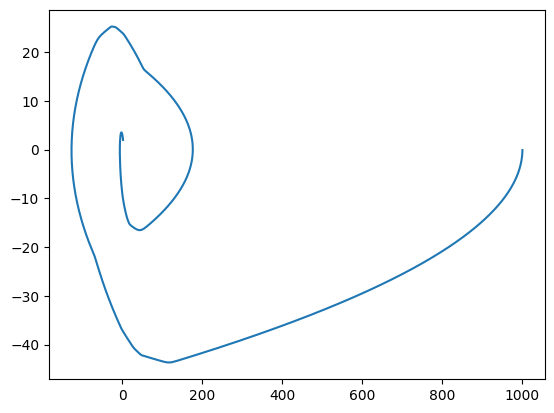

[34] loss: 5.748


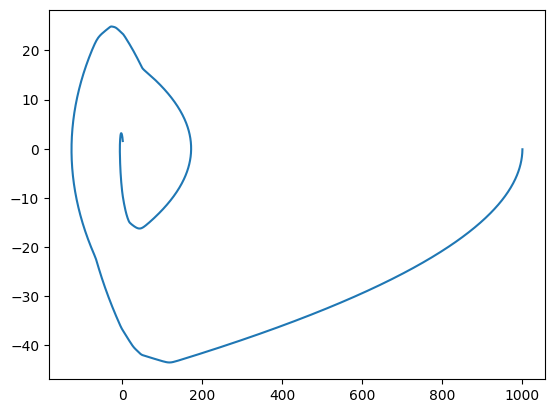

[35] loss: 4.596


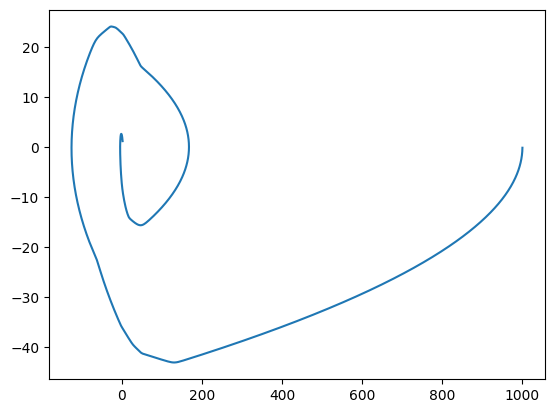

[36] loss: 3.908


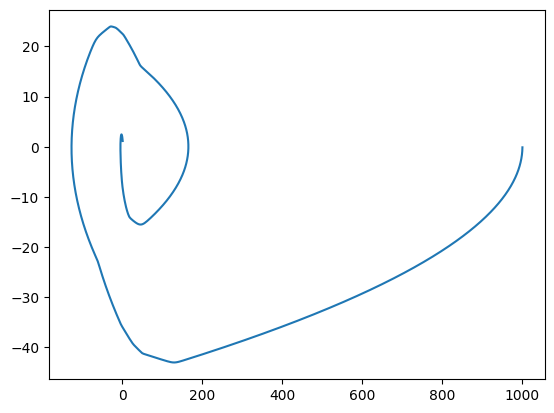

[37] loss: 3.217


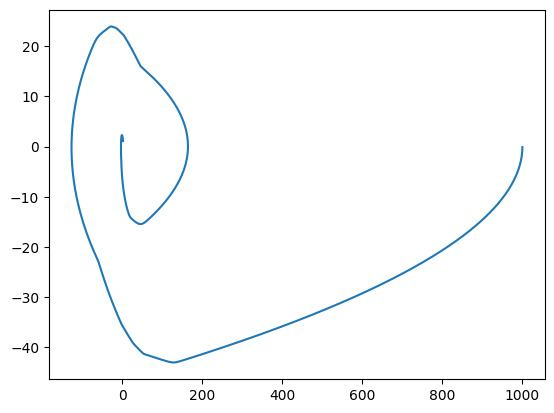

[38] loss: 2.421


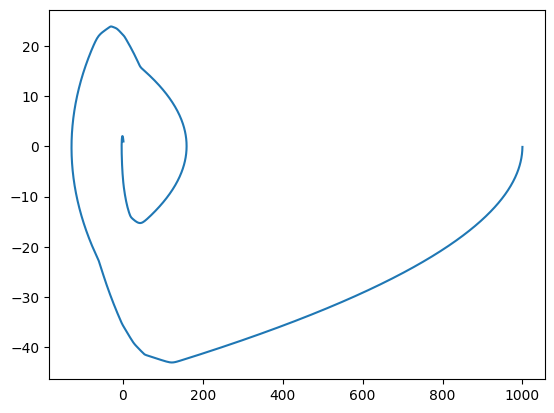

[39] loss: 1.934


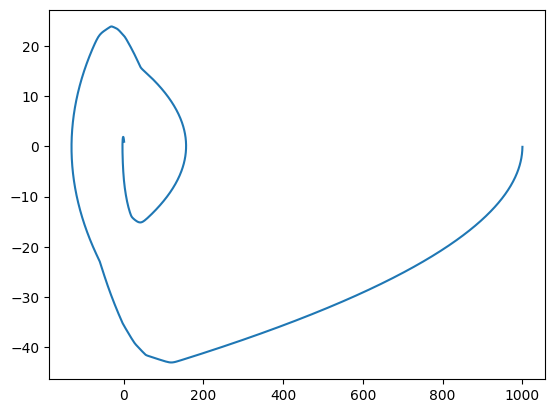

[40] loss: 1.445


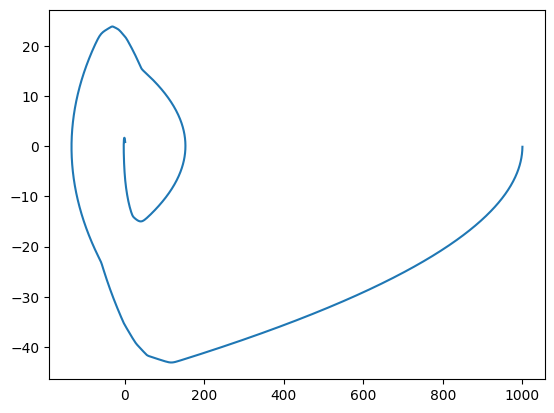

In [3]:
import logging
import math
import random
import numpy as np
import time

import torch
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

FRAME_TIME = 0.1
GRAVITY_ACCEL = 9.81
BOOST_ACCEL = 14.715
L_center_of_gravity = 5

PLATFORM_WIDTH = 25

class Dynmaics(nn.Module):

    def __init__(self):
        super(Dynmaics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action[0]: thrust
        action[1]: phi of thrust
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot
        state[4] = theta
        state[5] = omega
        """
        delta_state_gravity = t.tensor([0., -GRAVITY_ACCEL * FRAME_TIME, 0., 0., 0., 0])

        #Thrust Calculations
        state_tensor = torch.zeros((5,1))
        state_tensor[1,1] = torch.cos(state[4,1] + action[1])
        state_tensor[3,1] = torch.sin(state[4,1] + action[1])
        delta_state_thrust = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0])

        #omega calculations
        state_tensor_omega = torch.zeros((5,1))
        state_tensor_omega[4,1] = torch.sin(action[1])
        delta_state_omega = 4 * BOOST_ACCEL / L_center_of_gravity * FRAME_TIME * t.mul(t.tensor([0., 0., 0., 0., 0., 1]), action[0])


        state = state + delta_state_thrust + delta_state_gravity + delta_state_omega

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME],
                             [0., 0., 0., 0., 0., 1]])
        state = t.matmul(step_mat,state)

        return state

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to me
        """

        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )
    def forward(self, state):
        action = self.network(state)
        return action


class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1000., 0.] # need initial conditions
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.SGD(self.parameters, lr=0.02, momentum=0.8)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()


T = 1000
dim_input = 2
dim_hidden = 6
dim_output = 1
d = Dynmaics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(40)
